# FCNs for semantic segmentation

In this exercise we will look at the basics how to build a fully convolutional network for semantic segmentation.

## A first example

In [1]:
# install all needed packages
from typing import Tuple
import numpy as np
import skimage
import skimage.data
import skimage.io
import tensorflow.keras as keras


# for displaying images in jupyter
from matplotlib import pyplot as plt

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
#mpl.rcParams['figure.dpi']= 400

In [2]:
# check tensorflow installation to see if we have GPU support
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(keras.__version__)
import tensorflow
print(tensorflow.__version__)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16305824213082627757
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
locality {
  bus_id: 1
}
incarnation: 11079327386766882154
physical_device_desc: "device: 0, name: METAL, pci bus id: <undefined>"
xla_global_id: -1
]Metal device set to: Apple M1 Max

2.7.0
2.7.0


2023-12-04 10:27:00.816961: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-04 10:27:00.817079: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Images for smoke tests

When building a new network, it is a good idea to check if the network works at all, as it can sometimes take a while until all the hyper parameters are found. For that we generate a function to create some simple test images that we can use to test the network and if it is able to learn. (We will actually only use the test images in this exercise, as training on real images will take long).

For semantic segmentation, we need a label for each pixel. We will generate a noisy background image and paint a rectangle at a random position and size over the background. There will be two classes and each class will have a different mean pixel value with noise added.

In [3]:
def gen_random_binary_test_image(height: int, width: int)->(np.ndarray, np.ndarray):
    """
    Generate a test image and an appropriate label image with label 0 or label 1
    Label 0 images have a lower medium grayscale value, label 1 images a higher one.
    
    We will select one class for the background and then paint a rectangle over it of the other class.
    
    The returned images will have shape (height, width, 1) and type uint8 to be as compatible as possible to 
    images read from files
    """
    VALUE = [85, 170.0]
    CLASS_ID = [0, 1]
    NOISE = 20.0
    
    label = np.zeros((height, width, 1), dtype=np.uint8)
    class_id_bg = np.random.choice(CLASS_ID)
    class_id_fg = 1 - class_id_bg
    
    # paint background
    label.fill(class_id_bg)
    img = np.random.normal(VALUE[class_id_bg], NOISE, ((height, width, 1)))
    
    # start of the rectangle is in the first half
    fg_top = np.random.randint(low=0, high=height//2)
    fg_left = np.random.randint(low=0, high=width//2)
    
    # end of rectangle is in the second half
    fg_bottom = np.random.randint(low=height//2, high=height)
    fg_right = np.random.randint(low=width//2, high=width)
    
    # draw rectangle on label and image
    img[fg_top:fg_bottom, fg_left:fg_right] = np.random.normal(VALUE[class_id_fg], NOISE, (fg_bottom-fg_top, fg_right-fg_left, 1))
    label[fg_top:fg_bottom, fg_left:fg_right] = class_id_fg
    
    # make sure there are no values outside
    img = np.clip(img, 0.0, 255.0).astype(np.uint8)
    return img, label

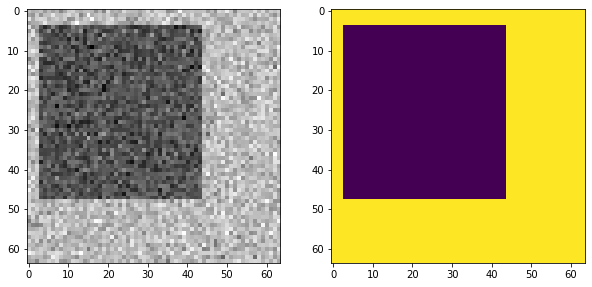

In [4]:
image, label = gen_random_binary_test_image(64, 64)
plt.subplot(1,2,1)
plt.imshow(image.reshape((image.shape[0], image.shape[1])), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(label.reshape((image.shape[0], image.shape[1])))

### Batch of data

Training is usually done using a batch of data. For semantic segmentation, that will be a batch of image (patches). We will also add the normalization of the data in this step. 

We will just scale the images in the range 0.0 to 1.0 from the full range of 0 to 255. Other possibilities are to scale the images individually according to their minimum and maximum values.


In [5]:
def gen_batch_binary(batch_size, height: int, width: int):
    image_list = []
    label_list = []
    for i in range(batch_size):
        img, label = gen_random_binary_test_image(height=height, width=width)
        image_list.append(img.astype(np.float32) / 255.0)
        label_list.append(label.astype(np.float32))

    image_batch = np.array(image_list, dtype=np.float32)
    label_batch = np.array(label_list, dtype=np.float32)

    # reshape labels as this is not done in the model
    label_batch = label_batch.reshape(batch_size, height,width, 1)

    return image_batch, label_batch

In [6]:
image_batch, label_batch = gen_batch_binary(100, 128, 128)
print(image_batch.shape)
print(label_batch.shape)

(100, 128, 128, 1)
(100, 128, 128, 1)


## Simple FCN

We will create a simple fully convolutional neural network for processing a batch of image patches

In [7]:
def fcn_simple_no_border(input_height:int, input_width:int) -> keras.Model:
    """
    Create a simple fcn model for semantic segmentation with 2 classes
    """
    model = keras.Sequential()
    
    # we use grayscale (1-channel input)
    
    # (used to define input shape on the first layers)
    model.add(keras.layers.Layer(input_shape=(input_height , input_width, 1)))
    
    # Downsampling (due to strides = 2)
    model.add(keras.layers.Convolution2D(filters=4, kernel_size=3, strides=(2, 2), padding='same', activation='relu'))
    
    # Upsampling with transpose convolutions
    model.add(keras.layers.Conv2DTranspose(filters=4, kernel_size=3, strides=(2, 2), padding='same', activation='relu'))
    
    # "normal" convolutional filter that preserves the size
    model.add(keras.layers.Convolution2D(filters=4, kernel_size=3, padding='same', activation='relu'))
    
    # go to logits which is the number of classes and add sigmoid layer for activation
    model.add(keras.layers.Convolution2D(filters=1, kernel_size=1, activation=None, 
                                         kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.001, seed=None)))
    model.add(keras.layers.Activation('sigmoid'))
    
    
    return model

In [8]:
model = fcn_simple_no_border(128, 128)

2023-12-04 10:27:01.031612: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-04 10:27:01.031630: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer (Layer)               (None, 128, 128, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 4)         40        
                                                                 
 conv2d_transpose (Conv2DTra  (None, 128, 128, 4)      148       
 nspose)                                                         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 4)       148       
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 1)       5         
                                                                 
 activation (Activation)     (None, 128, 128, 1)       0         
                                                        

In [10]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

Lets see if the model works....

In [11]:
history = model.fit(image_batch, label_batch, epochs=50, batch_size = 10, verbose=1)

Epoch 1/50


2023-12-04 10:27:01.164637: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-12-04 10:27:01.333531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<10x128x128x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 mus

 1/10 [==>...........................] - ETA: 4s - loss: 0.6931 - accuracy: 0.5013

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<10x128x128x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<10x128x128x1xi1>'


10/10 [==============================] - 1s 13ms/step - loss: 0.6927 - accuracy: 0.5099
Epoch 2/50
10/10 [==============================] - 0s 12ms/step - loss: 0.6906 - accuracy: 0.5203
Epoch 3/50
10/10 [==============================] - 0s 12ms/step - loss: 0.6870 - accuracy: 0.5203
Epoch 4/50
10/10 [==============================] - 0s 12ms/step - loss: 0.6816 - accuracy: 0.5203
Epoch 5/50
10/10 [==============================] - 0s 12ms/step - loss: 0.6758 - accuracy: 0.5203
Epoch 6/50
10/10 [==============================] - 0s 12ms/step - loss: 0.6699 - accuracy: 0.5203
Epoch 7/50
10/10 [==============================] - 0s 12ms/step - loss: 0.6634 - accuracy: 0.5203
Epoch 8/50
10/10 [==============================] - 0s 12ms/step - loss: 0.6562 - accuracy: 0.5203
Epoch 9/50
10/10 [==============================] - 0s 12ms/step - loss: 0.6477 - accuracy: 0.5203
Epoch 10/50
10/10 [==============================] - 0s 12ms/step - loss: 0.6386 - accuracy: 0.5212
Epoch 11/50
10/10 [=

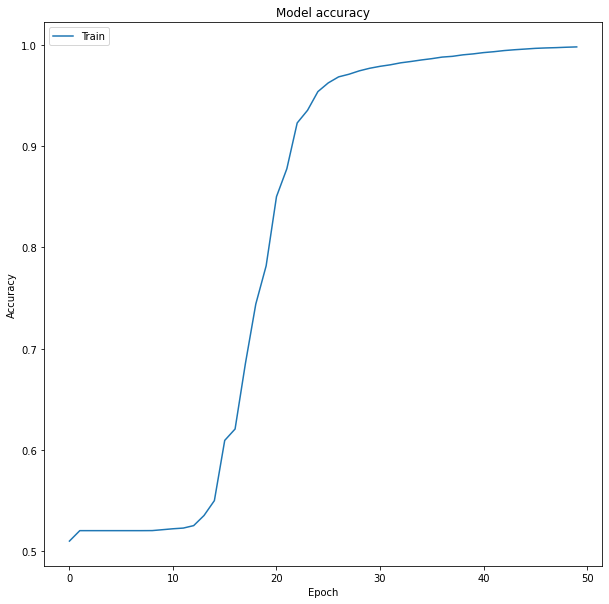

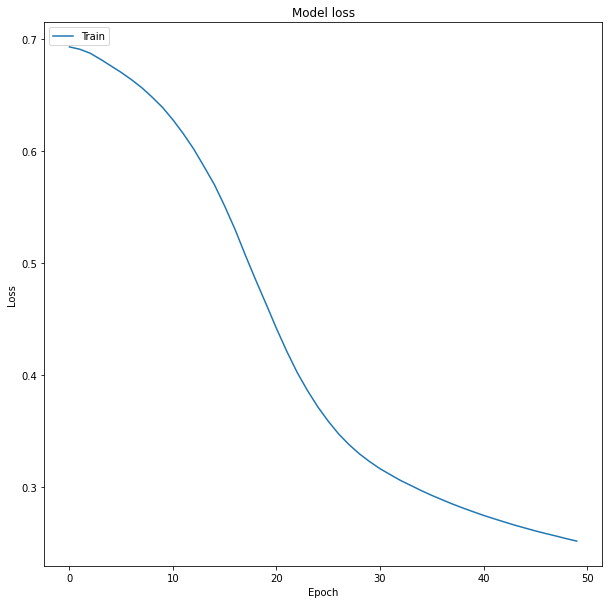

In [12]:
# Plot training accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

2023-12-04 10:27:07.757079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


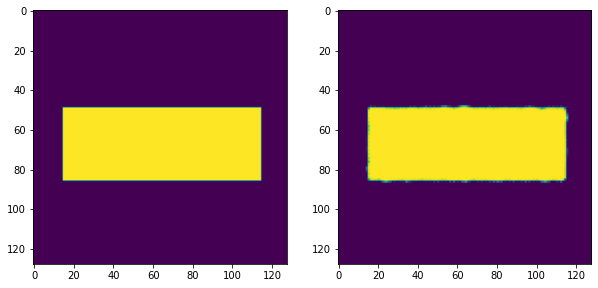

In [13]:
# Apply it to a test image and predict a result (for each pixel)
test_img, test_label = gen_batch_binary(1,128,128)
pred_label = model.predict(test_img)
plt.subplot(1,2,1)
plt.imshow(test_label[0,:,:,:])
plt.subplot(1,2,2)
plt.imshow(pred_label[0,:,:,:])

## Training with generators

Reading the whole data set into memory is not always possible. There are different possibilities to that problem, one is to use the Dataset classes in the tensorflow backend, there is an example how to do that on moodle. The other possibility is to use *generators* from python. A generator function to use for keras will generate a batch of data at the time. 

In [14]:
def batch_generator(batch_size, height: int, width: int):
    while True:
        image_batch, label_batch = gen_batch_binary(batch_size=batch_size, height=height, width=width)
        yield image_batch, label_batch

We can use fit as before, even with a generator.

In [15]:
PATCH_HEIGHT = 128
PATCH_WIDTH = 128
BATCH_SIZE = 50
EPOCHS = 50
STEPS_PER_EPOCHS = 10
model = fcn_simple_no_border(PATCH_HEIGHT, PATCH_WIDTH)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(
    batch_generator(BATCH_SIZE, PATCH_HEIGHT, PATCH_WIDTH),
        epochs=EPOCHS,
        verbose=1,
        steps_per_epoch=STEPS_PER_EPOCHS,
        shuffle=False,
        callbacks=None)

Epoch 1/50


2023-12-04 10:27:08.064007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<50x128x128x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/495c257e-668e-11ee-93ce-926038f30c31/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<50x128x128x1x

10/10 [==============================] - 1s 23ms/step - loss: 0.6930 - accuracy: 0.5148
Epoch 2/50
10/10 [==============================] - 0s 24ms/step - loss: 0.6925 - accuracy: 0.4881
Epoch 3/50
10/10 [==============================] - 0s 24ms/step - loss: 0.6911 - accuracy: 0.5345
Epoch 4/50
10/10 [==============================] - 0s 24ms/step - loss: 0.6887 - accuracy: 0.5070
Epoch 5/50
10/10 [==============================] - 0s 24ms/step - loss: 0.6840 - accuracy: 0.5040
Epoch 6/50
10/10 [==============================] - 0s 24ms/step - loss: 0.6760 - accuracy: 0.5076
Epoch 7/50
10/10 [==============================] - 0s 24ms/step - loss: 0.6659 - accuracy: 0.5041
Epoch 8/50
10/10 [==============================] - 0s 24ms/step - loss: 0.6532 - accuracy: 0.5024
Epoch 9/50
10/10 [==============================] - 0s 24ms/step - loss: 0.6279 - accuracy: 0.5336
Epoch 10/50
10/10 [==============================] - 0s 25ms/step - loss: 0.6167 - accuracy: 0.5143
Epoch 11/50
10/10 [=

## Exercise 1: Categorical data

In the example above we had only two classes, but in most applications we want to classify into more classes, as you have for example already done in the first homework, when classifying number.

Change the network and the generation of examples to use 5 classes.

In [16]:
# see solution below that uses both padding and categorical data


## Exercise 2: Padding

Also in the example, we used padding for the convolutional filters by specifying ```padding='same'```. However this will not process the data at the edges correctly as the missing data will be filled with 0. For training it is preferable to use only the data that fits inside the convolutional filters. This can be specified using ```padding='valid'```. However then the labels will have to be resized accordingly.

Change the network to use *valid* padding.

In [17]:
def fcn_simple_border(input_height:int, input_width:int, nr_classes:int) -> (keras.Model, int):
    """
    Create a simple fcn model for semantic segmentation with 2 classes.
    Return both the model and the border size
    """
    model = keras.Sequential()
    border = 0;
    
    # we use grayscale (1-channel input)
    
    # (used to define input shape on the first layers)
    model.add(keras.layers.Layer(input_shape=(input_height , input_width, 1)))
    
    # add 3 convolutional layers with 3x3 filters
    model.add(keras.layers.Convolution2D(filters=4, kernel_size=3, padding='valid', activation='relu'))
    border = border + 1
    model.add(keras.layers.Convolution2D(filters=8, kernel_size=3, padding='valid', activation='relu'))
    border = border + 1
    model.add(keras.layers.Convolution2D(filters=4, kernel_size=3, padding='valid', activation='relu'))
    border = border + 1
    
    # go to logits which is the number of classes and add softmax layer for activation
    model.add(keras.layers.Convolution2D(filters=nr_classes, kernel_size=1, activation=None, 
                                         kernel_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.001, seed=None)))
    model.add(keras.layers.Activation('softmax'))
    
    # reshape so that we have a sample for each pixel
   
    return model, border


In [18]:
model, border = fcn_simple_border(128, 128, 5)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_2 (Layer)             (None, 128, 128, 1)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 126, 126, 4)       40        
                                                                 
 conv2d_7 (Conv2D)           (None, 124, 124, 8)       296       
                                                                 
 conv2d_8 (Conv2D)           (None, 122, 122, 4)       292       
                                                                 
 conv2d_9 (Conv2D)           (None, 122, 122, 5)       25        
                                                                 
 activation_2 (Activation)   (None, 122, 122, 5)       0         
                                                                 
Total params: 653
Trainable params: 653
Non-trainable 

In [19]:
def gen_random_test_image_classes(height: int, width: int, nr_classes)->(np.ndarray, np.ndarray):
    """
    Generate a test image and an appropriate label image with label between 0 and the number of classes.
 
    
    
    The returned images will have shape (height, width, 1) and type uint8 to be as compatible as possible to 
    mages read from files
    """
    NOISE = 5.0
    
    class_id_bg = np.random.choice(range(nr_classes))
    class_id_fg = np.random.choice(range(nr_classes))
    
    # make sure that they are different, but this can also be ommitted
    while class_id_bg == class_id_fg:
        class_id_fg = np.random.choice(range(nr_classes))
    
    value_bg = (class_id_bg+1) * 255.0 / (nr_classes + 1.0)
    value_fg = (class_id_fg+1) * 255.0 / (nr_classes + 1.0)
    
    label = np.zeros((height, width, 1), dtype=np.uint8)
    
    # paint background
    label.fill(class_id_bg)
    img = np.random.normal(value_bg, NOISE, ((height, width, 1)))
    
    # start of the rectangle is in the first half
    fg_top = np.random.randint(low=0, high=height//2)
    fg_left = np.random.randint(low=0, high=width//2)
    
    # end of rectangle is in the second half
    fg_bottom = np.random.randint(low=height//2, high=height)
    fg_right = np.random.randint(low=width//2, high=width)
    
    # draw rectangle on label and image
    img[fg_top:fg_bottom, fg_left:fg_right] = np.random.normal(value_fg, NOISE, (fg_bottom-fg_top, fg_right-fg_left, 1))
    label[fg_top:fg_bottom, fg_left:fg_right] = class_id_fg
    
    # make sure there are no values outside
    img = np.clip(img, 0.0, 255.0).astype(np.uint8)
    
    return img, label

def gen_batch_binary_with_border(batch_size, height: int, width: int, border: int, nr_classes:int):
    image_list = []
    label_list = []
    for i in range(batch_size):
        img, label = gen_random_test_image_classes(height=height, width=width, nr_classes=nr_classes)
        label = label[border:-border, border:-border]
        image_list.append(img.astype(np.float32) / 255.0)
        label_list.append(label.astype(np.float32))

    image_batch = np.array(image_list, dtype=np.float32)
    label_batch = np.array(label_list, dtype=np.float32)

    # reshape labels as this is not done in the model
    # label_batch = label_batch.reshape(batch_size, (height-2*border)*(width-2*border), 1)
    label_batch = keras.utils.to_categorical(label_batch, num_classes=nr_classes)

    return image_batch, label_batch

def batch_generator_with_border(batch_size, height: int, width: int, border: int, nr_classes:int):
    while True:
        image_batch, label_batch = gen_batch_binary_with_border(batch_size=batch_size, 
                                                                height=height, width=width, 
                                                                border=border, nr_classes=nr_classes)
        yield image_batch, label_batch
        

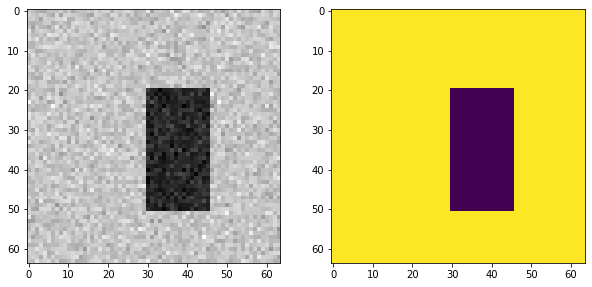

In [20]:
image, label = gen_random_test_image_classes(64, 64, 4)
plt.subplot(1,2,1)
plt.imshow(image.reshape((image.shape[0], image.shape[1])), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(label.reshape((image.shape[0], image.shape[1])))

In [55]:
PATCH_HEIGHT = 128
PATCH_WIDTH = 128
BATCH_SIZE = 128
EPOCHS = 20
STEPS_PER_EPOCHS = 100
NR_CLASSES = 5
model, border = fcn_simple_border(PATCH_HEIGHT, PATCH_WIDTH, NR_CLASSES)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
        batch_generator_with_border(BATCH_SIZE, PATCH_HEIGHT, PATCH_WIDTH, border, NR_CLASSES),
        epochs=EPOCHS,
        verbose=1,
        steps_per_epoch=STEPS_PER_EPOCHS,
        shuffle=False,
        callbacks=None)

Epoch 1/20


2023-12-04 10:50:12.129350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 9s 86ms/step - loss: 1.4826 - accuracy: 0.2943
Epoch 2/20
100/100 [==============================] - 9s 86ms/step - loss: 0.7907 - accuracy: 0.6962
Epoch 3/20
100/100 [==============================] - 9s 87ms/step - loss: 0.2366 - accuracy: 0.9786
Epoch 4/20
100/100 [==============================] - 9s 86ms/step - loss: 0.1264 - accuracy: 0.9786
Epoch 5/20
100/100 [==============================] - 9s 86ms/step - loss: 0.1037 - accuracy: 0.9791
Epoch 6/20
100/100 [==============================] - 9s 86ms/step - loss: 0.0956 - accuracy: 0.9795
Epoch 7/20
100/100 [==============================] - 9s 88ms/step - loss: 0.0888 - accuracy: 0.9799
Epoch 8/20
100/100 [==============================] - 9s 88ms/step - loss: 0.0835 - accuracy: 0.9805
Epoch 9/20
100/100 [==============================] - 9s 87ms/step - loss: 0.0806 - accuracy: 0.9804
Epoch 10/20
100/100 [==============================] - 9s 89ms/step - loss: 0.0776 - accuracy: 0.9809


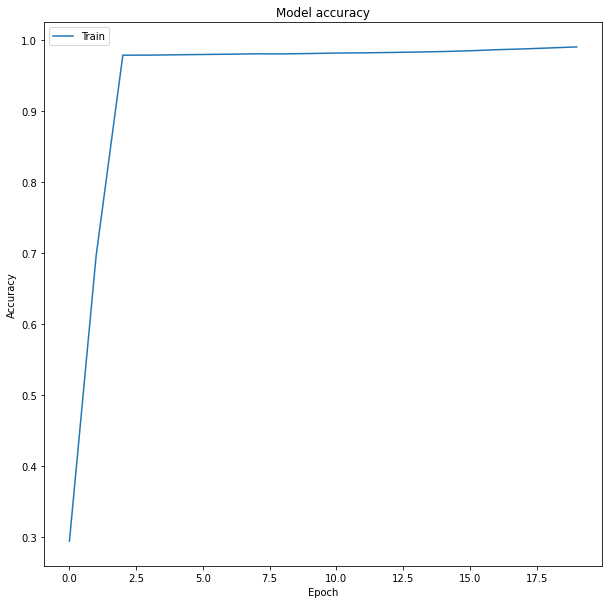

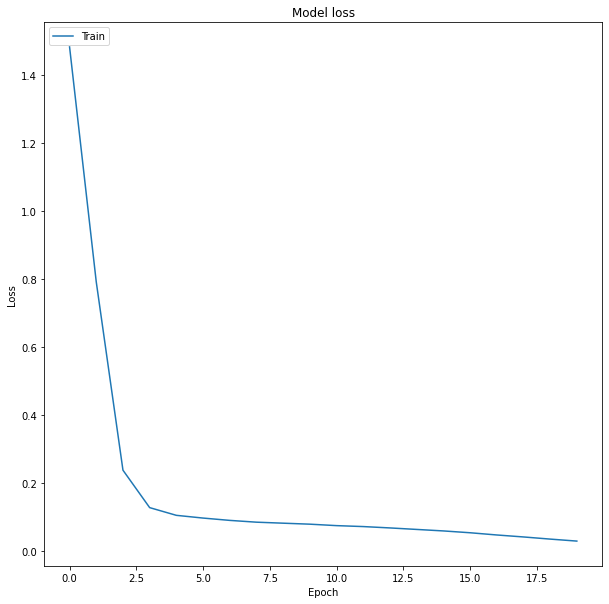

In [56]:
# Plot training accuracy values
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

# Plot training loss values
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [60]:
model.summary()
result = model.evaluate(batch_generator_with_border(BATCH_SIZE, PATCH_HEIGHT, PATCH_WIDTH, border, NR_CLASSES),steps=10)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer_4 (Layer)             (None, 128, 128, 1)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 126, 126, 4)       40        
                                                                 
 conv2d_15 (Conv2D)          (None, 124, 124, 8)       296       
                                                                 
 conv2d_16 (Conv2D)          (None, 122, 122, 4)       292       
                                                                 
 conv2d_17 (Conv2D)          (None, 122, 122, 5)       25        
                                                                 
 activation_4 (Activation)   (None, 122, 122, 5)       0         
                                                                 
Total params: 653
Trainable params: 653
Non-trainable 

0.2
(122, 122)
3.043671056167697


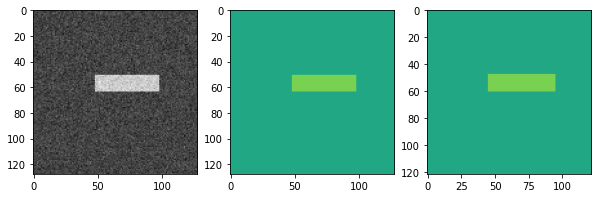

In [64]:
img, label = gen_random_test_image_classes(height=PATCH_HEIGHT, width=PATCH_WIDTH, nr_classes=NR_CLASSES)
# normalize image
img = img.astype(np.float32) / 255.0
pred_label = model.predict(np.expand_dims(img, axis=0))
print(pred_label.mean())
pred_class = np.argmax(pred_label[0,:,:,:], axis=2)
print(pred_class.shape)
print(pred_class.mean())

plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.subplot(1,3,2)
plt.imshow(label, vmin=0, vmax=NR_CLASSES)
plt.subplot(1,3,3)
plt.imshow(pred_class, vmin=0, vmax=NR_CLASSES)


    

## Exercise 3: Data preparation for homework 2

In the homework, you should train a network to recognise different categories from the cityscapes data base for autonomous driving. A link to the data set is available in moodle, it is a small copy of the data where the images have been divided into smaller patches for easier processing. 

More information about the data set can be found here: https://www.cityscapes-dataset.com/

First, let us look at the label distribution in the training data. Load the label images and calculate a histogram of the labels.

Also find the maximal id that occurs in the label images.

In [24]:
from pathlib import Path
p = Path("/Users/toko/data/test/")
pattern = 'test_lbl*.png'
label_files = list(p.glob(pattern))
first = True
r = list(range(257))
for file in label_files:
    label =  skimage.io.imread(file)
    if first:
        global_histogram, _ = np.histogram(label, bins=r)
        n_labels = 1
        first = False
        m = np.max(label)
    else:
        histogram, _ = np.histogram(label, bins=r)
        global_histogram += histogram
        m2 = np.max(label)
        m = max(m, m2)
        n_labels += 1
        
print(global_histogram / n_labels)
print(m)

[3.16419492e+00 2.54793750e+03 0.00000000e+00 9.88562500e+02
 9.73867585e+02 2.67949153e+02 6.67847193e+03 1.61374804e+04
 2.10556303e+03 3.09758475e+02 0.00000000e+00 1.61782039e+04
 1.19424258e+03 3.29902013e+02 2.05709746e+01 0.00000000e+00
 0.00000000e+00 3.88047140e+02 3.73993644e+00 3.68326271e+00
 2.55320445e+02 1.09412632e+04 8.62003708e+02 2.01851589e+03
 1.31897775e+02 1.60423729e+01 2.54776430e+03 5.56622881e+02
 2.44385593e+00 0.00000000e+00 2.81991525e+00 0.00000000e+00
 1.08898305e+00 6.90720339e+01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

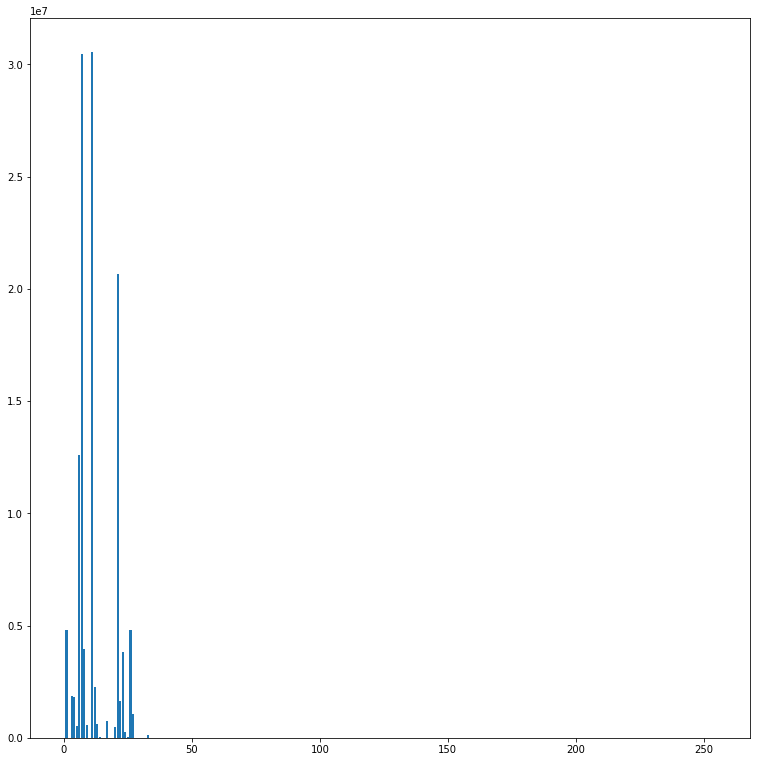

In [25]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(np.arange(256),global_histogram)
plt.show()

Plot an image and its label image.

In [26]:
selection = '058_12'
image_file = p / ('test_img_' + selection + '.png')
label_file = p / ('test_lbl_' + selection + '.png')

In [27]:
image = skimage.io.imread(image_file)
label = skimage.io.imread(label_file)

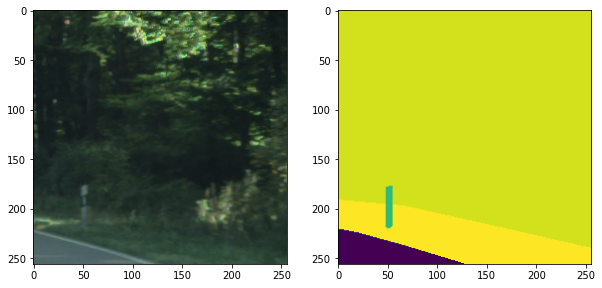

In [28]:
plt.subplot(1,2,1)
plt.imshow(image)
plt.subplot(1,2,2)
plt.imshow(label)

In [29]:
print(label.shape)

(256, 256)


In [30]:
print(np.max(label))

22
